# Install Libraries

In [ ]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 749.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 32.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
!pip install PyWavelets

In [ ]:
import wfdb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read record and extract PCG signal

In [ ]:
record = wfdb.rdrecord('/content/drive/MyDrive/MachineLearning_Project/Final Dataset/ECGPCG0001')

In [ ]:
fs = record.fs
print(fs)

8000


In [ ]:
print(record.sig_name)           # to know channle of pcg
print(record.p_signal.shape)

['ECG', 'PCG']
(1920000, 2)


In [ ]:
pcg_signal = record.p_signal[:,1]

In [ ]:
pcg_signal

array([ 0.00059833,  0.00089749,  0.00089749, ..., -0.02842057,
       -0.02782225, -0.02782225])

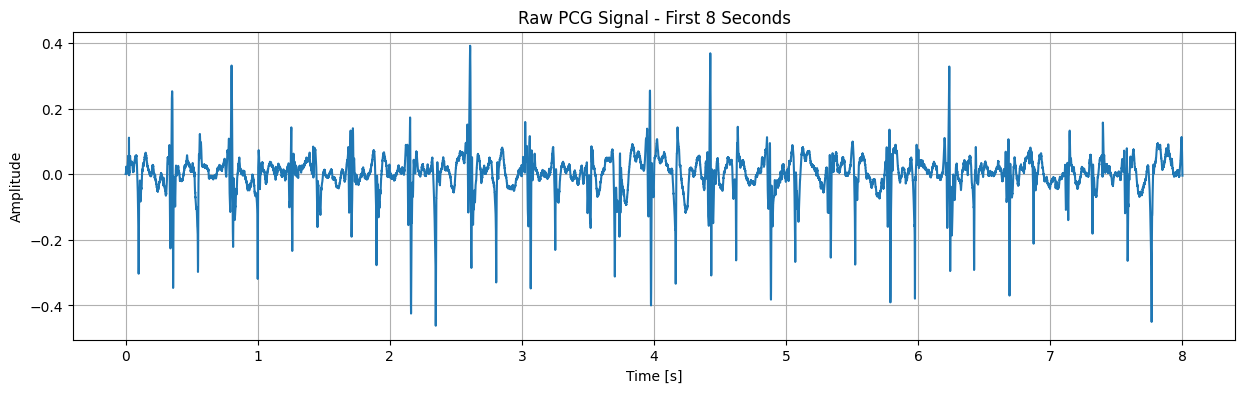

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


duration_sec = 8
fs = 8000
samples = fs * duration_sec

plt.figure(figsize=(15, 4))
plt.plot(np.arange(samples) / fs, pcg_signal[:samples])
plt.title('Raw PCG Signal - First 8 Seconds')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.show()


In [ ]:
def moving_average(signal, window_size=100):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='same')



# Signal Denoising

In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt
from skimage.restoration import denoise_wavelet

class SignalPreprocessing:
    def __init__(self, audio_signal, sr):
        self.signal = audio_signal
        self.sr = sr

    def process_wavelet_denoising(self,zoom_1=0, zoom_2=None):

        wl_signal = denoise_wavelet(self.signal, method='BayesShrink', mode='soft', wavelet_levels=5,
                                    wavelet='sym8', rescale_sigma=True)
        return wl_signal


    def process_digital_filter(self, order=4, low_fc=25, high_fc=400):
        nyq = 0.5 * self.sr
        low = low_fc / nyq
        high = high_fc / nyq
        b, a = butter(order, [low, high], btype='band')

        denoised = filtfilt(b, a, self.signal)
        return b, denoised



In [ ]:
def calculate_snr(original_signal, denoised_signal):
    """Calculate Signal-to-Noise Ratio (SNR)."""
    noise = original_signal - denoised_signal
    snr = 10 * np.log10(np.sum(original_signal ** 2) / np.sum(noise ** 2))
    return snr

def calculate_psnr(original_signal, denoised_signal, max_val=1.0):
    """Calculate Peak Signal-to-Noise Ratio (PSNR)."""
    mse = np.mean((original_signal - denoised_signal) ** 2)
    if mse == 0:
        return 100  # Ideal PSNR if no error
    psnr = 10 * np.log10((max_val ** 2) / mse)
    return psnr

In [ ]:
signal_processing = SignalPreprocessing(pcg_signal, record.fs)

In [ ]:
pcg_wavelet_denoising = signal_processing.process_wavelet_denoising()

In [ ]:
_,pcg_digital_filter_denoising = signal_processing.process_digital_filter()

In [ ]:
pcg_digital_filter_denoising

array([0.00170573, 0.00169067, 0.00167774, ..., 0.00537906, 0.00491767,
       0.00448426])

In [ ]:
print(f"Wavelet Denoising - SNR: {calculate_snr(pcg_signal,pcg_wavelet_denoising):.2f} dB, PSNR: {calculate_psnr(pcg_signal,pcg_wavelet_denoising):.2f} dB")
print(f"Digital Filter Denoising - SNR: {calculate_snr(pcg_signal,pcg_digital_filter_denoising):.2f} dB, PSNR: {calculate_psnr(pcg_signal,pcg_digital_filter_denoising):.2f} dB")

Wavelet Denoising - SNR: 48.67 dB, PSNR: 71.86 dB
Digital Filter Denoising - SNR: 3.56 dB, PSNR: 26.75 dB


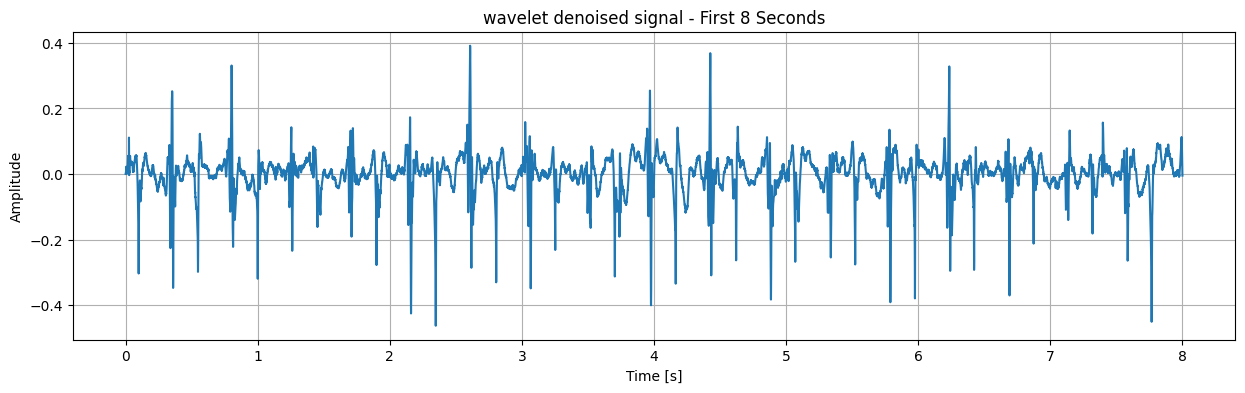

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


duration_sec = 8
fs = record.fs
samples = fs * duration_sec

plt.figure(figsize=(15, 4))
plt.plot(np.arange(samples) / fs, pcg_wavelet_denoising[:samples])
plt.title('wavelet denoised signal - First 8 Seconds')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.show()


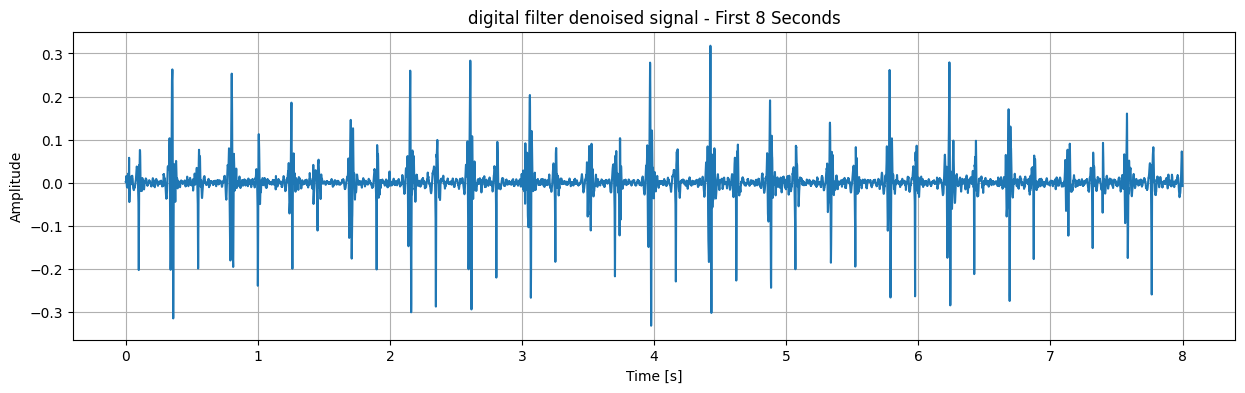

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


duration_sec = 8
fs = record.fs
samples = fs * duration_sec

plt.figure(figsize=(15, 4))
plt.plot(np.arange(samples) / fs, pcg_digital_filter_denoising[:samples])
plt.title('digital filter denoised signal - First 8 Seconds')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.show()


# Feature Extraction

In [ ]:
# feature extraction libraries:
import librosa
import librosa.display
import scipy.signal
import pywt

## constants

In [ ]:
FEATURE_TYPE = 'DENORMALIZED_IMAGES'  # 'NORMALIZED_TABULAR', 'DENORMALIZED_TABULAR', 'NORMALIZED_IMAGES' or 'DENORMALIZED_IMAGES'
FRAME_SIZE = 512
HOP_SIZE = 64
SPLIT_FREQUENCY = 256
N_MELS = 128
N_MFCCS = 13
N_SCALES = 30

## Time Domain Features

In [ ]:
class TimeDomainFeatures:
    def __init__(self, audio_signal, frame_size =512, hop_size =64):
        self.audio_signal = audio_signal
        self.frame_size = frame_size
        self.hop_size = hop_size

    def extract_descriptive_statistics(self):
        """Function to extract the Descriptive Statistics of a signal"""
        maximum = np.max(self.audio_signal)
        minimum = np.min(self.audio_signal)
        median = np.median(self.audio_signal)
        mean = np.mean(self.audio_signal)
        std = np.std(self.audio_signal)
        return maximum, minimum, mean, median, std

    def extract_energy_power(self):
        """Function to calculate the Energy  and the total power of the signal."""
        time_interval = len(self.audio_signal)
        energy = np.sum((abs(self.audio_signal)) ** 2)
        total_power = energy / time_interval
        return energy, total_power

    def extract_amplitude_envelope(self, plot=False, des_stats=bool):
        """Function to extract the Amplitude Envelope of each frame of a signal. It returns
        either a plot, descriptive statistics or an array of amplitude envelope"""
        audio_signal = np.array(self.audio_signal)
        ae = np.array([max(audio_signal[i: i + self.frame_size]) for i in range(0, len(audio_signal), self.hop_size)])

        # Plotting the amplitude envelope:
        if plot:
            # to plot the frames alongside with the processed_signal, the frames required to be converted into time
            frames = range(0, ae.size)
            t = librosa.frames_to_time(frames, hop_length=self.hop_size)

            plt.figure(figsize=(15, 5))
            librosa.display.waveshow(audio_signal, alpha=0.5)
            plt.title('Amplitude Envelope')
            plt.plot(t, ae, color='r')
            return plt.show()
        # Returning the descriptive statistics of the amplitude envelope:
        elif des_stats:
            ae = np.array(ae)
            maximum = np.max(ae)
            minimum = np.min(ae)
            median = np.median(ae)
            mean = np.mean(ae)
            std = np.std(ae)
            return maximum, minimum, mean, median, std
        # Returning the amplitude envelope:
        else:
            return np.array(ae)

    def extract_root_mean_square(self, plot=False, des_stats=bool):
        """Function to extract the Root Mean Square Energy of each frame of a signal. It returns
        either a plot, descriptive statistics or an array of Root Mean Square Energy"""
        audio_signal = np.array(self.audio_signal)
        rms = librosa.feature.rms(y=audio_signal, frame_length=self.frame_size, hop_length=self.hop_size)[0]


        # Plotting the rms:
        if plot:
            # to plot the frames alongside with the processed_signal, the frames required to be converted into time
            frames = range(0, rms.size)
            t = librosa.frames_to_time(frames, hop_length=self.hop_size)

            plt.figure(figsize=(15, 5))
            librosa.display.waveshow(audio_signal, alpha=0.5)
            plt.title('Root Mean Square Energy')
            plt.plot(t, rms, color='r')
            return plt.show()
        # Returning the descriptive statistics of the Root Mean Square Energy:
        elif des_stats:
            rms = np.array(rms)
            maximum = np.max(rms)
            minimum = np.min(rms)
            median = np.median(rms)
            mean = np.mean(rms)
            std = np.std(rms)
            return maximum, minimum, mean, median, std
        # Returning the Root Mean Square Energy:
        else:
            return np.array(rms)

    def extract_zero_crossing_rate(self, frames=bool, plot=False, des_stats=bool):
        """Function to extract the Zero-Crossing Rate of each frame of a signal. It returns
        either a plot, descriptive statistics or an array of Zero-Crossing Rate or Zero-Crossing
        Rate of the complete signal. the 'frames' indicates whether the calculations by frames
        or for the complete signal."""
        # retrieve the Zero-Crossing Rate for each frame by using frame_size and hop_size:
        audio_signal = np.array(self.audio_signal)
        if frames:
            zcr = librosa.feature.zero_crossing_rate(audio_signal,
                                                     frame_length=self.frame_size,
                                                     hop_length=self.hop_size)[0]

            # Plotting the Zero-Crossing Rate over the frames:
            if plot:
                frames_range = range(0, zcr.size)
                t = librosa.frames_to_time(frames_range, hop_length=self.hop_size)

                plt.figure(figsize=(15, 5))
                plt.plot(t, zcr, color='r', alpha=0.5)
                plt.title('Zero-Crossing Rate')
                plt.ylim((0, 0.3))
                return plt.show()
            # Returning the descriptive statistics of the Zero-Crossing Rate:
            elif des_stats:
                zcr = np.array(zcr)
                maximum = np.max(zcr)
                minimum = np.min(zcr)
                median = np.median(zcr)
                mean = np.mean(zcr)
                std = np.std(zcr)
                return maximum, minimum, mean, median, std
            # Returning the Zero-Crossing Rate:
            else:
                return np.array(zcr)
        # Retrieve the Zero-Crossing Rate for the complete signal:
        else:
            zcr = librosa.zero_crossings(audio_signal)
            zcr = np.sum(zcr) / len(zcr)
            return zcr




In [ ]:
TIME_DOMAIN = TimeDomainFeatures(audio_signal=pcg_wavelet_denoising)

In [ ]:
MAX, MIN, MEAN, MEDIAN, STD=TIME_DOMAIN.extract_descriptive_statistics()
print(MAX, MIN, MEAN, MEDIAN, STD)

0.607485927453223 -0.6172049740993691 -0.0008167827028873075 0.00462198466640528 0.0692242581229398


In [ ]:
ENERGY, POWER = TIME_DOMAIN.extract_energy_power()
print(ENERGY, POWER)

9201.91688957786 0.004792665046655135


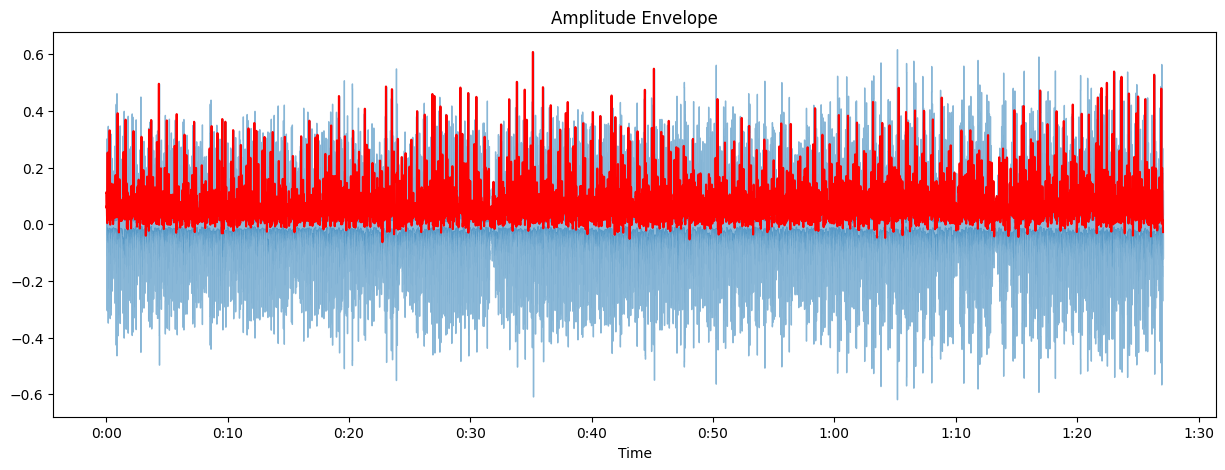

In [ ]:
TIME_DOMAIN.extract_amplitude_envelope(plot=True, des_stats=False)


In [ ]:
AE_MAX, AE_MIN, AE_MEAN, AE_MEDIAN, AE_STD = TIME_DOMAIN.extract_amplitude_envelope(plot=False, des_stats=True)

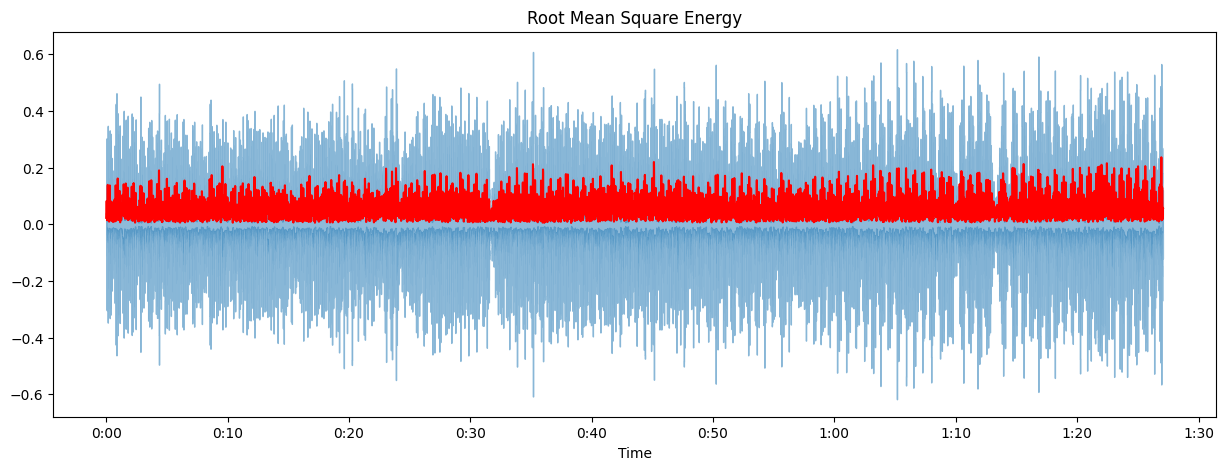

In [ ]:
TIME_DOMAIN.extract_root_mean_square(plot=True, des_stats=False)


In [ ]:
RM_MAX, RM_MIN, RM_MEAN, RM_MEDIAN, RM_STD = TIME_DOMAIN.extract_root_mean_square(plot=False, des_stats=True)

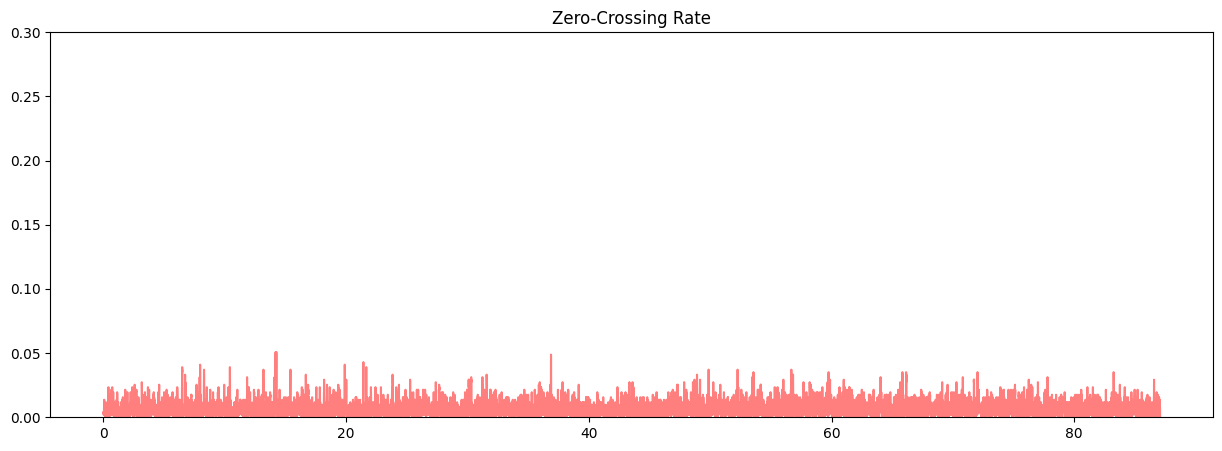

In [ ]:
TIME_DOMAIN.extract_zero_crossing_rate(frames=True, plot=True, des_stats=False)

In [ ]:
ZCR_MAX, ZCR_MIN, ZCR_MEAN, ZCR_MEDIAN, ZCR_STD = TIME_DOMAIN.extract_zero_crossing_rate(frames=True,
                                                                                         plot=False,
                                                                                         des_stats=True)

In [ ]:
ZCR = TIME_DOMAIN.extract_zero_crossing_rate(frames=False, plot=False, des_stats=False)

## Frequency Domain Features

In [ ]:
class FrequencyDomainFeatures:
    def __init__(self, audio_signal, sr, frame_size =512, hop_size=64):
        self.audio_signal = audio_signal
        self.sr = sr
        self.frame_size = frame_size
        self.hop_size = hop_size

    def extract_spectrum_features(self, plot=False):
        """Function to extract the spectrum features of a signal. It returns the amplitude and
        the frequency values of the peak value."""
        audio_signal = np.array(self.audio_signal)
        ft = scipy.fft.fft(audio_signal)
        magnitude = np.absolute(ft)
        frequency = np.linspace(0, self.sr, len(magnitude))
        frequency_range = int(len(frequency) * 0.5)

        peak_amplitude = np.max(magnitude)  # Maximum amplitude
        peak_frequency = frequency[np.argmax(magnitude)]  # The frequency of the maximum amplitude

        # Plotting the spectrum:
        if plot:
            plt.figure(figsize=(15, 5))
            plt.plot(frequency[:frequency_range], magnitude[:frequency_range])
            plt.title('Spectrum')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Magnitude')
            return plt.show()
        else:
            return peak_amplitude, peak_frequency

    def extract_band_energy_ratio(self, split_frequency, plot=False, des_stats=bool):
        """Function to extract the Band Energy Ratio of each frame of a signal. It returns
        either a plot, descriptive statistics or an array of Band Energy Ratio."""
        # calculating the spectrogram:
        audio_signal = np.array(self.audio_signal)
        spec = librosa.stft(audio_signal, n_fft=self.frame_size, hop_length=self.hop_size)

        # calculating the split frequency bin
        frequency_range = self.sr / 2
        frequency_delta_per_bin = frequency_range / spec.shape[0]
        split_frequency_bin = np.floor(split_frequency / frequency_delta_per_bin)

        # move to the power spectrogram:
        power_spectrogram = np.abs(spec) ** 2
        power_spectrogram = power_spectrogram.T

        # calculating the band energy ratio for each frame:
        ber = []
        for frequencies_in_frame in power_spectrogram:
            sum_power_low_frequencies = np.sum(frequencies_in_frame[:int(split_frequency_bin)])
            sum_power_high_frequencies = np.sum(frequencies_in_frame[int(split_frequency_bin):])
            ber_current_frame = sum_power_low_frequencies / sum_power_high_frequencies
            ber.append(ber_current_frame)

        # Plotting the Band Energy Ratio:
        if plot:
            frames = range(len(ber))
            t = librosa.frames_to_time(frames, hop_length=self.hop_size)

            plt.figure(figsize=(15, 5))
            plt.plot(t, ber)
            return plt.show()
        # Returning the descriptive statistics of the Band Energy Ratio:
        elif des_stats:
            ber = np.array(ber)
            maximum = np.max(ber)
            minimum = np.min(ber)
            median = np.median(ber)
            mean = np.mean(ber)
            std = np.std(ber)
            return maximum, minimum, mean, median, std
        # Returning the Band Energy Ratio:
        else:
            return np.array(ber)

    def extract_spectral_centroid(self, plot=False, des_stats=bool):
        """Function to extract the Spectral Centroid of each frame of a signal. It returns
        either a plot, descriptive statistics or an array of Spectral Centroid."""
        audio_signal = np.array(self.audio_signal)
        sc = librosa.feature.spectral_centroid(y=audio_signal,
                                               sr=self.sr,
                                               n_fft=self.frame_size,
                                               hop_length=self.hop_size)[0]

        # Plotting the Spectral Centroid:
        if plot:
            frames = range(len(sc))
            t = librosa.frames_to_time(frames)

            plt.figure(figsize=(15, 5))
            plt.plot(t, sc)
            plt.title('Spectral Centroid')
            return plt.show
        # Returning the descriptive statistics of the Spectral Centroid:
        elif des_stats:
            sc = np.array(sc)
            maximum = np.max(sc)
            minimum = np.min(sc)
            median = np.median(sc)
            mean = np.mean(sc)
            std = np.std(sc)
            return maximum, minimum, mean, median, std
        # Returning the Spectral Centroid:
        else:
            return sc

    def extract_spectral_bandwidth(self, plot=False, des_stats=bool):
        """Function to extract the Spectral Centroid of each frame of a signal. It returns
        either a plot, descriptive statistics or an array of Spectral Bandwidth."""
        audio_signal = np.array(self.audio_signal)
        sb = librosa.feature.spectral_bandwidth(y=audio_signal,
                                                sr=self.sr,
                                                n_fft=self.frame_size,
                                                hop_length=self.hop_size)[0]

        # Plotting the Spectral Bandwidth:
        if plot:
            frames = range(len(sb))
            t = librosa.frames_to_time(frames)

            plt.figure(figsize=(15, 5))
            plt.plot(t, sb)
            plt.title('Spectral Bandwidth')
            return plt.show
        # Returning the descriptive statistics of the Spectral Bandwidth:
        elif des_stats:
            sb = np.array(sb)
            maximum = np.max(sb)
            minimum = np.min(sb)
            median = np.median(sb)
            mean = np.mean(sb)
            std = np.std(sb)
            return maximum, minimum, mean, median, std
        # Returning the Spectral Bandwidth:
        else:
            return sb




In [ ]:
FREQ_DOMAIN = FrequencyDomainFeatures(audio_signal=pcg_wavelet_denoising,sr=record.fs)

In [ ]:
PA, PF = FREQ_DOMAIN.extract_spectrum_features(plot=False) #'Peak Amplitude', 'Peak Frequency

In [ ]:
BER_MAX, BER_MIN, BER_MEAN,BER_MEDIAN, BER_STD = FREQ_DOMAIN.extract_band_energy_ratio(split_frequency=SPLIT_FREQUENCY,
                                                                                        plot=False,
                                                                                        des_stats=True)

In [ ]:
SC_MAX, SC_MIN, SC_MEAN,SC_MEDIAN, SC_STD = FREQ_DOMAIN.extract_spectral_centroid(plot=False,
                                                                                      des_stats=True)

In [ ]:

SB_MAX, SB_MIN, SB_MEAN,SB_MEDIAN, SB_STD = FREQ_DOMAIN.extract_spectral_bandwidth(plot=False,
                                                                                       des_stats=True)

## Time_Frequency Domain Features

In [ ]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pywt

class TimeFrequencyDomainFeatures:
    def __init__(self, audio_signal, sr, frame_size=512, hop_size=64):
        self.audio_signal = audio_signal
        self.sr = sr
        self.frame_size = frame_size
        self.hop_size = hop_size

    def extract_spectrogram(self, plot=False, save=False, img_ref=None):
        """Funtion to extract the Spectrogram of a signal. It either returns a plot or save
        the image in 'data/extracted_features/images' directory."""
        audio_signal = np.array(self.audio_signal)
        signal_stft = librosa.stft(audio_signal, n_fft=self.frame_size, hop_length=self.hop_size)
        signal_stft_log = librosa.power_to_db(np.abs(signal_stft) ** 2)

        # plotting the spectrogram:
        if plot:
            plt.figure(figsize=(15, 5))
            librosa.display.specshow(signal_stft_log, sr=self.sr, hop_length=self.hop_size, x_axis='time', y_axis='log')
            plt.colorbar(format='%+2.f')
            plt.title('Spectrogram')
            return plt.show()
        # Saving the plot in the defined path
        elif save:
            if img_ref is None:
                raise ValueError("'img_ref' argument must be specified")
            figure = plt.figure(figsize=(1.28, 1.28))
            ax = plt.axes()
            ax.set_axis_off()
            librosa.display.specshow(signal_stft_log, sr=self.sr, hop_length=self.hop_size, x_axis='time', y_axis='log')
            plt.savefig(f'{c.FEATURE_EXTRACTION_PATH}/images/spectrogram/{img_ref}.png')
            return plt.close(figure)

    def extract_mel_spectrogram(self, n_mels=128, plot=False, save=False, img_ref=None):
        """Extracts the Mel spectrogram from the audio signal."""
        audio_signal = np.array(self.audio_signal)  # Convert audio signal to numpy array

        # Generate Mel spectrogram
        signal_mel = librosa.feature.melspectrogram(y=audio_signal,  # 'y' is the audio signal
                                                    sr=self.sr,
                                                    n_fft=self.frame_size,
                                                    hop_length=self.hop_size,
                                                    n_mels=n_mels)

        # Convert to dB scale (log scale)
        signal_mel_db = librosa.power_to_db(signal_mel, ref=np.max)

        # Optionally, plot the Mel spectrogram
        if plot:
            plt.figure(figsize=(10, 6))
            librosa.display.specshow(signal_mel_db, x_axis='time', y_axis='mel', sr=self.sr)
            plt.colorbar(format='%+2.0f dB')
            plt.title('Mel Spectrogram')
            plt.show()

        # Optionally, save the Mel spectrogram as an image
        if save:
            if img_ref is None:
                img_ref = "mel_spectrogram_image"
            file_path = os.path.join("data/extracted_features/images", f"{img_ref}.png")
            plt.figure(figsize=(10, 6))
            librosa.display.specshow(signal_mel_db, x_axis='time', y_axis='mel', sr=self.sr)
            plt.colorbar(format='%+2.0f dB')
            plt.title('Mel Spectrogram')
            plt.savefig(file_path)
            plt.close()

        return signal_mel_db  # Return the Mel spectrogram


    def extract_mfccs(self, mfcc_type: str, plot=False, save=False, img_ref=None, des_stats=False, n_mfcc=13):
        """Funtion to extract the MFCCs of a signal. 'mfcc_type' is either 'mfccs', 'delta_1'
        or 'delta_2'. It either returns a plot, save the image in 'data/extracted_features/images'
        directory or the descriptive statistics."""
        audio_signal = np.array(self.audio_signal)
        mfccs = librosa.feature.mfcc(y=audio_signal, n_mfcc=n_mfcc, sr=self.sr)

        if mfcc_type == 'mfccs':
            if plot:
                plt.figure(figsize=(15, 5))
                librosa.display.specshow(mfccs, x_axis='time', sr=self.sr)
                plt.title('Mel-Frequency Cepstral Coefficients')
                return plt.show()
            elif save:
                if img_ref is None:
                    raise ValueError("'img_ref' argument must be specified")
                figure = plt.figure(figsize=(1.28, 1.28))
                ax = plt.axes()
                ax.set_axis_off()
                librosa.display.specshow(mfccs, x_axis='time', sr=self.sr)
                plt.savefig(f'{c.FEATURE_EXTRACTION_PATH}/images/mfccs/mfcc/{img_ref}.png')
                return plt.close(figure)
            elif des_stats:
                return np.max(mfccs), np.min(mfccs), np.mean(mfccs), np.median(mfccs), np.std(mfccs)
            else:
                return np.array(mfccs)
        elif mfcc_type == 'delta_1':
            delta_1 = librosa.feature.delta(mfccs)
            if plot:
                plt.figure(figsize=(15, 5))
                librosa.display.specshow(delta_1, x_axis='time', sr=self.sr)
                plt.title('MFCCs - Delta_1')
                return plt.show()
            elif save:
                if img_ref is None:
                    raise ValueError("'img_ref' argument must be specified")
                figure = plt.figure(figsize=(1.28, 1.28))
                ax = plt.axes()
                ax.set_axis_off()
                librosa.display.specshow(delta_1, x_axis='time', sr=self.sr)
                plt.savefig(f'{c.FEATURE_EXTRACTION_PATH}/images/mfccs/delta_1/{img_ref}.png')
                return plt.close(figure)
            elif des_stats:
                return np.max(delta_1), np.min(delta_1), np.mean(delta_1), np.median(delta_1), np.std(delta_1)
            else:
                return np.array(delta_1)
        elif mfcc_type == 'delta_2':
            delta_2 = librosa.feature.delta(mfccs, order=2)
            if plot:
                plt.figure(figsize=(15, 5))
                librosa.display.specshow(delta_2, x_axis='time', sr=self.sr)
                plt.title('MFCCs - Delta_2')
                return plt.show()
            elif save:
                if img_ref is None:
                    raise ValueError("'img_ref' argument must be specified")
                figure = plt.figure(figsize=(1.28, 1.28))
                ax = plt.axes()
                ax.set_axis_off()
                librosa.display.specshow(delta_2, x_axis='time', sr=self.sr)
                plt.savefig(f'{c.FEATURE_EXTRACTION_PATH}/images/mfccs/delta_2/{img_ref}.png')
                return plt.close(figure)
            elif des_stats:
                return np.max(delta_2), np.min(delta_2), np.mean(delta_2), np.median(delta_2), np.std(delta_2)
            else:
                return np.array(delta_2)

    def extract_cwt_scalogram(self, wavelet_family: str, plot=False, save=False, img_ref=None, num_scales =10):
        """Funtion to extract the cwt_scalogram of a signal. 'wavelet_family': 'gaus1', 'cgau1',
        'cmor', 'fbsp', 'mexh', 'morl' or 'shan'. It either returns a plot or save the image
        in 'data/extracted_features/images' directory."""

        scales_range = np.arange(1, num_scales)
        coefficients, frequencies = pywt.cwt(data=self.audio_signal, scales=scales_range, wavelet=wavelet_family)

        # plotting the Scalogram:
        if plot:
            plt.figure(figsize=(15, 5))
            plt.imshow(abs(coefficients), extent=[0, 200, 30, 1], interpolation='bilinear',
                       cmap='bone', aspect='auto', vmax=abs(coefficients).max(),
                       vmin=-abs(coefficients).max())
            plt.gca().invert_yaxis()
            plt.yticks(np.arange(1, 31, 1))
            plt.xticks(np.arange(0, 201, 10))
            return plt.show()

        # Saving the Scalogram in the defined path:
        elif save:
            if img_ref is None:
                raise ValueError("'img_ref' argument must be specified.")
            figure = plt.figure(figsize=(1.28, 1.28))
            ax = plt.axes()
            ax.set_axis_off()
            plt.imshow(abs(coefficients), extent=[0, 200, 30, 1], interpolation='bilinear',
                       cmap='bone', aspect='auto', vmax=abs(coefficients).max(),
                       vmin=-abs(coefficients).max())
            plt.gca().invert_yaxis()
            plt.savefig(f'{c.FEATURE_EXTRACTION_PATH}/images/scalogram/{img_ref}.png')
            plt.close(figure)

        else:
            return np.array(coefficients), np.array(frequencies)

    def extract_dwt_coefficients(self, dwt_levels=False, plot=False, des_stats=False):
        """Function to extract the dwt_coefficients of a signal. if 'dwt_levels' is True, it
        extract five levels of the dwt, otherwise only one level. It either returns a plot or
        save the image in 'data/extracted_features/images' directory."""
        audio_signal = self.audio_signal
        if dwt_levels:
            coefficients = pywt.wavedec(data=audio_signal, wavelet='bior3.1', level=5, mode='periodic')
            ca5, cd5, cd4, cd3, cd2, cd1 = coefficients
            # Plotting the coefficients of the 5 levels:
            if plot:
                audio_signals = [audio_signal, cd1, cd2, cd3, cd4, cd5]
                plot_titles = ['Original Signal', 'cd1', 'cd2', 'cd3', 'cd4', 'cd5']
                fig, axs = plt.subplots(len(audio_signals), 1, figsize=(15, 10))
                for i, (signal, title) in enumerate(zip(audio_signals, plot_titles)):
                    axs[i].plot(signal)
                    axs[i].set_title(title)
                    axs[i].set_xlabel('Time')
                    axs[i].set_ylabel('Amplitude')
                    fig.tight_layout(pad=2.0)
                return plt.show()
            else:
                return ca5, cd5, cd4, cd3, cd2, cd1
        else:
            ca, cd = pywt.dwt(data=audio_signal, wavelet='coif1')
            if des_stats:
                ca_max = np.max(ca)
                ca_min = np.min(ca)
                ca_mean = np.mean(ca)
                ca_median = np.median(ca)
                ca_std = np.std(cd)
                cd_max = np.max(cd)
                cd_min = np.min(cd)
                cd_mean = np.mean(cd)
                cd_median = np.median(cd)
                cd_std = np.std(cd)
                return ca_max, ca_min, ca_mean, ca_median, ca_std, cd_max, cd_min, cd_mean, cd_median, cd_std
            else:
                return ca, cd

In [ ]:
TIME_FREQ_DOMAIN = TimeFrequencyDomainFeatures(audio_signal=pcg_wavelet_denoising,
                                                             sr=record.fs)

In [ ]:
# Mel frequency Cepstral Coefficients (MFCCs):
MFCC_NORMAL_MAX, MFCC_NORMAL_MIN, MFCC_NORMAL_MEAN,MFCC_NORMAL_MEDIAN, MFCC_NORMAL_STD = TIME_FREQ_DOMAIN.extract_mfccs(
                                                                                   mfcc_type='mfccs',
                                                                                   des_stats=True)

In [ ]:
DELTA1_NORMAL_MAX, DELTA1_NORMAL_MIN, DELTA1_NORMAL_MEAN,DELTA1_NORMAL_MEDIAN, DELTA1_NORMAL_STD = TIME_FREQ_DOMAIN.extract_mfccs(
                                                                                       mfcc_type='delta_1',
                                                                                       des_stats=True)

In [ ]:
DELTA2_NORMAL_MAX, DELTA2_NORMAL_MIN, DELTA2_NORMAL_MEAN,DELTA2_NORMAL_MEDIAN, DELTA2_NORMAL_STD = TIME_FREQ_DOMAIN.extract_mfccs(
                                                                                       mfcc_type='delta_2',
                                                                                       des_stats=True)

In [ ]:
#Discrete Wavelet Transform - Coefficients: >>one level comparison
CA_NORMAL_MAX, CA_NORMAL_MIN, CA_NORMAL_MEAN,CA_NORMAL_MEDIAN, CA_NORMAL_STD,CD_NORMAL_MAX, CD_NORMAL_MIN, CD_NORMAL_MEAN,CD_NORMAL_MEDIAN, CD_NORMAL_STD = TIME_FREQ_DOMAIN.extract_dwt_coefficients(dwt_levels=False,
                                                                                          des_stats=True)

In [ ]:
#Discrete Wavelet Transform - Coefficients:>>multi level comparison
_, CD5_NORMAL, CD4_NORMAL, CD3_NORMAL,CD2_NORMAL, CD1_NORMAL = TIME_FREQ_DOMAIN.extract_dwt_coefficients(dwt_levels=True)

# Full record Script

In [ ]:
import pandas as pd
import os
import wfdb


data_dir = '/content/drive/MyDrive/MachineLearning_Project/Final Dataset'
feature_rows = []

for file in os.listdir(data_dir):
    if file.endswith('.hea'):
        record_name = os.path.splitext(file)[0]
        try:

            record = wfdb.rdrecord(os.path.join(data_dir, record_name))
            pcg_signal = record.p_signal[:, 1]  # pcg is in channel 1

            # denoising using wavlet as it show high snr
            signal_processor = SignalPreprocessing(pcg_signal, record.fs)
            pcg_wavelet = signal_processor.process_wavelet_denoising()

            # time domain features
            time_feat = TimeDomainFeatures(pcg_wavelet)
            desc_stats = time_feat.extract_descriptive_statistics()
            energy_stats = time_feat.extract_energy_power()
            ae_stats = time_feat.extract_amplitude_envelope(des_stats=True)
            rms_stats = time_feat.extract_root_mean_square(des_stats=True)
            zcr_stats = time_feat.extract_zero_crossing_rate(frames=True, des_stats=True)
            zcr_global = time_feat.extract_zero_crossing_rate(frames=False)

            # freq domain feature
            freq_feat = FrequencyDomainFeatures(pcg_wavelet, record.fs)
            peak_amp, peak_freq = freq_feat.extract_spectrum_features()
            ber_stats = freq_feat.extract_band_energy_ratio(SPLIT_FREQUENCY, des_stats=True)
            sc_stats = freq_feat.extract_spectral_centroid(des_stats=True)
            sb_stats = freq_feat.extract_spectral_bandwidth(des_stats=True)

            # time freq domain feature
            tf_feat = TimeFrequencyDomainFeatures(pcg_wavelet, record.fs)
            mfcc_stats = tf_feat.extract_mfccs('mfccs', des_stats=True)
            delta1_stats = tf_feat.extract_mfccs('delta_1', des_stats=True)
            delta2_stats = tf_feat.extract_mfccs('delta_2', des_stats=True)
            dwt_stats = tf_feat.extract_dwt_coefficients(dwt_levels=False, des_stats=True)

            # combine all with the name of record
            feature_row = list(desc_stats) + list(energy_stats) + list(ae_stats) + list(rms_stats) + \
                          list(zcr_stats) + [zcr_global] + \
                          [peak_amp, peak_freq] + list(ber_stats) + list(sc_stats) + list(sb_stats) + \
                          list(mfcc_stats) + list(delta1_stats) + list(delta2_stats) + list(dwt_stats) + \
                          [record_name]  # label

            feature_rows.append(feature_row)

        except Exception as e:
            print(f"Failed to process {record_name}: {e}")

# col name
columns = [
    # time domain
    'MAX', 'MIN', 'MEAN', 'MEDIAN', 'STD',
    'ENERGY', 'POWER',
    'AE_MAX', 'AE_MIN', 'AE_MEAN', 'AE_MEDIAN', 'AE_STD',
    'RM_MAX', 'RM_MIN', 'RM_MEAN', 'RM_MEDIAN', 'RM_STD',
    'ZCR_MAX', 'ZCR_MIN', 'ZCR_MEAN', 'ZCR_MEDIAN', 'ZCR_STD',
    'ZCR_GLOBAL',
    # frequency domain
    'PEAK_AMP', 'PEAK_FREQ',
    'BER_MAX', 'BER_MIN', 'BER_MEAN', 'BER_MEDIAN', 'BER_STD',
    'SC_MAX', 'SC_MIN', 'SC_MEAN', 'SC_MEDIAN', 'SC_STD',
    'SB_MAX', 'SB_MIN', 'SB_MEAN', 'SB_MEDIAN', 'SB_STD',
    # MFCC
    'MFCC_MAX', 'MFCC_MIN', 'MFCC_MEAN', 'MFCC_MEDIAN', 'MFCC_STD',
    'DELTA1_MAX', 'DELTA1_MIN', 'DELTA1_MEAN', 'DELTA1_MEDIAN', 'DELTA1_STD',
    'DELTA2_MAX', 'DELTA2_MIN', 'DELTA2_MEAN', 'DELTA2_MEDIAN', 'DELTA2_STD',
    # DWT
    'CA_MAX', 'CA_MIN', 'CA_MEAN', 'CA_MEDIAN', 'CA_STD',
    'CD_MAX', 'CD_MIN', 'CD_MEAN', 'CD_MEDIAN', 'CD_STD',
    # label y
    'RECORD_NAME'
]

# save data
df = pd.DataFrame(feature_rows, columns=columns)
df.to_csv('/content/drive/MyDrive/MachineLearning_Project/pcg_features.csv', index=False)
print("Saved extracted features to CSV.")


Saved extracted features to CSV.


### labels conversion >> Rest , Medium , High

In [ ]:
def map_stress_level(label):
    label = label.lower()
    if 'rest' in label or 'laying' in label or 'sitting' in label:
        return 'Rest'
    elif 'walk' in label or 'sit down' in label or 'stand up' in label:
        return 'Medium'
    elif 'bicycle' in label or 'pedaling' in label or 'treadmill' in label:
        return 'High'
    else:
        return 'Unknown'

In [ ]:
df_label = pd.read_csv('/content/drive/MyDrive/MachineLearning_Project/Final Dataset/labels.csv')

In [ ]:
df_label.head()

,Record Name,Label
0,ECGPCG0001,Exercise: pedaling a stationary bicycle
1,ECGPCG0013,Rest: laying on bed
2,ECGPCG0019_1,Slow walk
3,ECGPCG0019_2,Fast walk
4,ECGPCG0019_3,Sit down and stand up


In [ ]:
df_label["Stress_Level"] = df_label["Label"].apply(map_stress_level)

In [ ]:
df_label.head()

,Record Name,Label,Stress_Level
0,ECGPCG0001,Exercise: pedaling a stationary bicycle,High
1,ECGPCG0013,Rest: laying on bed,Rest
2,ECGPCG0019_1,Slow walk,Medium
3,ECGPCG0019_2,Fast walk,Medium
4,ECGPCG0019_3,Sit down and stand up,Medium


In [ ]:
df_label.drop('Label', axis=1, inplace=True)


In [ ]:
df_label.head()

,Record Name,Stress_Level
0,ECGPCG0001,High
1,ECGPCG0013,Rest
2,ECGPCG0019_1,Medium
3,ECGPCG0019_2,Medium
4,ECGPCG0019_3,Medium


In [ ]:
df_label.to_csv('/content/drive/MyDrive/MachineLearning_Project/stress_level_labels.csv', index=False)

### convert the pcg_feature with record name to be with stress level

In [ ]:
df.head()

,MAX,MIN,MEAN,MEDIAN,STD,ENERGY,POWER,AE_MAX,AE_MIN,AE_MEAN,...,CA_MIN,CA_MEAN,CA_MEDIAN,CA_STD,CD_MAX,CD_MIN,CD_MEAN,CD_MEDIAN,CD_STD,RECORD_NAME
0,0.584746,-0.989883,-0.000789,0.002027,0.056535,6138.000576,0.003197,0.584746,-0.265582,0.060032,...,-1.402961,-0.001116,0.002860,0.000211,0.102568,-0.110090,-2.082197e-07,-3.503422e-07,0.000211,ECGPCG0002
1,0.607486,-0.617205,-0.000817,0.004622,0.069224,9201.916890,0.004793,0.607486,-0.063343,0.084502,...,-0.872447,-0.001155,0.006537,0.000183,0.003917,-0.003646,7.548140e-09,8.132405e-08,0.000183,ECGPCG0001
2,0.958774,-0.988808,0.000235,-0.001997,0.092992,16603.372243,0.008648,0.958774,-0.743674,0.079078,...,-1.398367,0.000332,-0.002806,0.000322,0.097673,-0.075290,-1.280732e-06,-9.676913e-07,0.000322,ECGPCG0013
3,0.377058,-0.688211,0.000172,0.001580,0.038216,2804.110828,0.001460,0.377058,-0.025836,0.044219,...,-0.973167,0.000244,0.002234,0.000127,0.016806,-0.025325,4.590091e-08,-4.204741e-07,0.000127,ECGPCG0010
4,0.994622,-0.990815,-0.012910,-0.002584,0.494585,469979.390960,0.244781,0.994622,-0.530497,0.554603,...,-1.401666,-0.018256,-0.003655,0.001093,0.057569,-0.054559,-1.546283e-06,-2.239015e-06,0.001093,ECGPCG0024


In [ ]:
df_merged = pd.merge(df, df_label, left_on='RECORD_NAME', right_on='Record Name', how='left')

In [ ]:
df_merged

,MAX,MIN,MEAN,MEDIAN,STD,ENERGY,POWER,AE_MAX,AE_MIN,AE_MEAN,...,CA_MEDIAN,CA_STD,CD_MAX,CD_MIN,CD_MEAN,CD_MEDIAN,CD_STD,RECORD_NAME,Record Name,Stress_Level
0,0.584746,-0.989883,-0.000789,0.002027,0.056535,6138.000576,0.003197,0.584746,-0.265582,0.060032,...,0.002860,0.000211,0.102568,-0.110090,-2.082197e-07,-3.503422e-07,0.000211,ECGPCG0002,ECGPCG0002,High
1,0.607486,-0.617205,-0.000817,0.004622,0.069224,9201.916890,0.004793,0.607486,-0.063343,0.084502,...,0.006537,0.000183,0.003917,-0.003646,7.548140e-09,8.132405e-08,0.000183,ECGPCG0001,ECGPCG0001,High
2,0.958774,-0.988808,0.000235,-0.001997,0.092992,16603.372243,0.008648,0.958774,-0.743674,0.079078,...,-0.002806,0.000322,0.097673,-0.075290,-1.280732e-06,-9.676913e-07,0.000322,ECGPCG0013,ECGPCG0013,Rest
3,0.377058,-0.688211,0.000172,0.001580,0.038216,2804.110828,0.001460,0.377058,-0.025836,0.044219,...,0.002234,0.000127,0.016806,-0.025325,4.590091e-08,-4.204741e-07,0.000127,ECGPCG0010,ECGPCG0010,Rest
4,0.994622,-0.990815,-0.012910,-0.002584,0.494585,469979.390960,0.244781,0.994622,-0.530497,0.554603,...,-0.003655,0.001093,0.057569,-0.054559,-1.546283e-06,-2.239015e-06,0.001093,ECGPCG0024,ECGPCG0024,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.992892,-0.989896,-0.001149,0.004804,0.129632,32267.079541,0.016806,0.992892,-0.850777,0.053020,...,0.006801,0.000304,0.039941,-0.063372,-1.001698e-06,-9.982357e-07,0.000304,ECGPCG0018_5,ECGPCG0018_5,Rest
69,0.993293,-0.988577,0.000383,-0.011094,0.322529,199728.008859,0.104025,0.993293,-0.633532,0.307384,...,-0.015707,0.000296,0.028349,-0.032568,-3.642299e-07,9.769094e-08,0.000296,ECGPCG0017_2,ECGPCG0017_2,Medium
70,0.994161,-0.989664,-0.004773,-0.016877,0.467594,419840.358847,0.218667,0.994161,-0.935410,0.478998,...,-0.023883,0.000498,0.037970,-0.042518,-2.160669e-06,2.472384e-07,0.000498,ECGPCG0017_3,ECGPCG0017_3,Medium
71,0.993589,-0.990210,0.003051,0.001475,0.360497,249537.147234,0.129967,0.993589,-0.982937,0.362178,...,0.002086,0.000500,0.041287,-0.051881,-9.020074e-07,1.004936e-06,0.000500,ECGPCG0017_4,ECGPCG0017_4,Medium


In [ ]:
df_merged.drop('RECORD_NAME', axis=1, inplace=True)


In [ ]:
df_merged.drop('Record Name', axis=1, inplace=True)

In [ ]:
df_merged.head()

,MAX,MIN,MEAN,MEDIAN,STD,ENERGY,POWER,AE_MAX,AE_MIN,AE_MEAN,...,CA_MIN,CA_MEAN,CA_MEDIAN,CA_STD,CD_MAX,CD_MIN,CD_MEAN,CD_MEDIAN,CD_STD,Stress_Level
0,0.584746,-0.989883,-0.000789,0.002027,0.056535,6138.000576,0.003197,0.584746,-0.265582,0.060032,...,-1.402961,-0.001116,0.002860,0.000211,0.102568,-0.110090,-2.082197e-07,-3.503422e-07,0.000211,High
1,0.607486,-0.617205,-0.000817,0.004622,0.069224,9201.916890,0.004793,0.607486,-0.063343,0.084502,...,-0.872447,-0.001155,0.006537,0.000183,0.003917,-0.003646,7.548140e-09,8.132405e-08,0.000183,High
2,0.958774,-0.988808,0.000235,-0.001997,0.092992,16603.372243,0.008648,0.958774,-0.743674,0.079078,...,-1.398367,0.000332,-0.002806,0.000322,0.097673,-0.075290,-1.280732e-06,-9.676913e-07,0.000322,Rest
3,0.377058,-0.688211,0.000172,0.001580,0.038216,2804.110828,0.001460,0.377058,-0.025836,0.044219,...,-0.973167,0.000244,0.002234,0.000127,0.016806,-0.025325,4.590091e-08,-4.204741e-07,0.000127,Rest
4,0.994622,-0.990815,-0.012910,-0.002584,0.494585,469979.390960,0.244781,0.994622,-0.530497,0.554603,...,-1.401666,-0.018256,-0.003655,0.001093,0.057569,-0.054559,-1.546283e-06,-2.239015e-06,0.001093,High


In [ ]:
df_merged.to_csv('/content/drive/MyDrive/MachineLearning_Project/pcg_features_With_stress_level.csv', index=False)